<a href="https://colab.research.google.com/github/deniskaanikov/ML/blob/main/%D0%BB%D0%B0%D0%B15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Загрузка данных

In [ ]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
#Импортируем его при помощи библиотеки Pandas
column_names = ['Расход топлива','Кол-во цилиндров','Объем двигателя','Л.с.','Вес',
                'Разгон до 100 км/ч', 'Год выпуска', 'Страна выпуска']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,Страна выпуска
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Подготовка данных

In [ ]:
#очистка данных
dataset.isna().sum()

,0
Расход топлива,0
Кол-во цилиндров,0
Объем двигателя,0
Л.с.,6
Вес,0
Разгон до 100 км/ч,0
Год выпуска,0
Страна выпуска,0


In [ ]:
#удаление рядов
dataset = dataset.dropna()

In [ ]:
#замена категориальных значений на двоичный код
origin = dataset.pop("Страна выпуска")

dataset['США'] = (origin == 1)*1.0
dataset['Европа'] = (origin == 2)*1.0
dataset['Япония'] = (origin == 3)*1.0
dataset.tail()


,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,США,Европа,Япония
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Разделим на тренировочные и проверочные данные

In [ ]:
#Теперь нам необходимо разделить данные на две части: для обучения и для проверки.
#Точность получившейся модели мы сможем проверить на втором наборе данных.
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Проверим данные

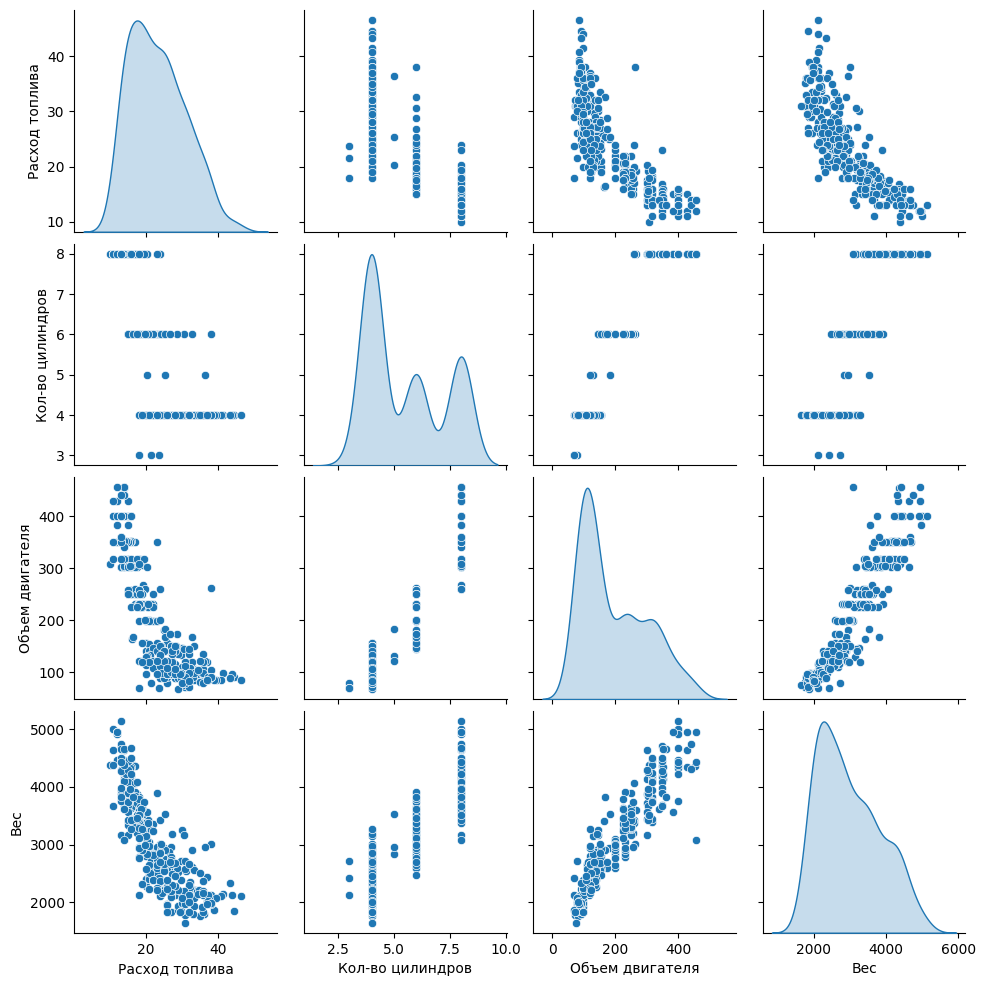

In [ ]:
sns.pairplot(train_dataset[["Расход топлива", "Кол-во цилиндров", "Объем двигателя", "Вес"]], diag_kind="kde")

In [ ]:
#Общая статистика
train_stats = train_dataset.describe()
train_stats.pop("Расход топлива")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Кол-во цилиндров,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Объем двигателя,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Л.с.,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Вес,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Разгон до 100 км/ч,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Год выпуска,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
США,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Европа,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Япония,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Выделим значения

In [ ]:
#отделить целевое значение от остальных параметров
train_labels = train_dataset.pop('Расход топлива')
test_labels = test_dataset.pop('Расход топлива')

Нормализуем данные

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Построим модель

In [ ]:
#Мы будем использовать Sequential(последовательную) модель с двумя полносвязными Dense слоями,
#а выходящий слой будет возвращать одно постоянно изменяющееся значение.
#Все этапы построения модели мы опишем в функции build_model, так как позже мы создадим еще одну модель.
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Проверим модель

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Все готово, теперь мы можем опробовать нашу модель.
#Для начала попробуем небольшой батч из 10 примеров данных
#из тренировочного набора и попробуем предсказать результат.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


array([[-0.17987573],
       [ 0.0433881 ],
       [-0.49427006],
       [-0.03044502],
       [ 0.11847221],
       [-0.16834524],
       [ 0.05707961],
       [-0.25053105],
       [-0.21521601],
       [-0.2408524 ]], dtype=float32)

Обучим модель

In [ ]:
# обучать модель в течение 1000 эпох и
# фиксировать точность модели на тренировочных и проверочных данных в объекте history.
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
#визуализация процесса
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.723776,0.961925,2.723776,9.792302,2.248596,9.792302,995
996,2.731904,1.013528,2.731904,9.571177,2.329279,9.571177,996
997,2.496031,0.954355,2.496031,9.665672,2.275076,9.665672,997
998,2.603826,1.002783,2.603826,9.600101,2.278085,9.600101,998
999,2.637175,0.982563,2.637175,9.339332,2.268909,9.339332,999


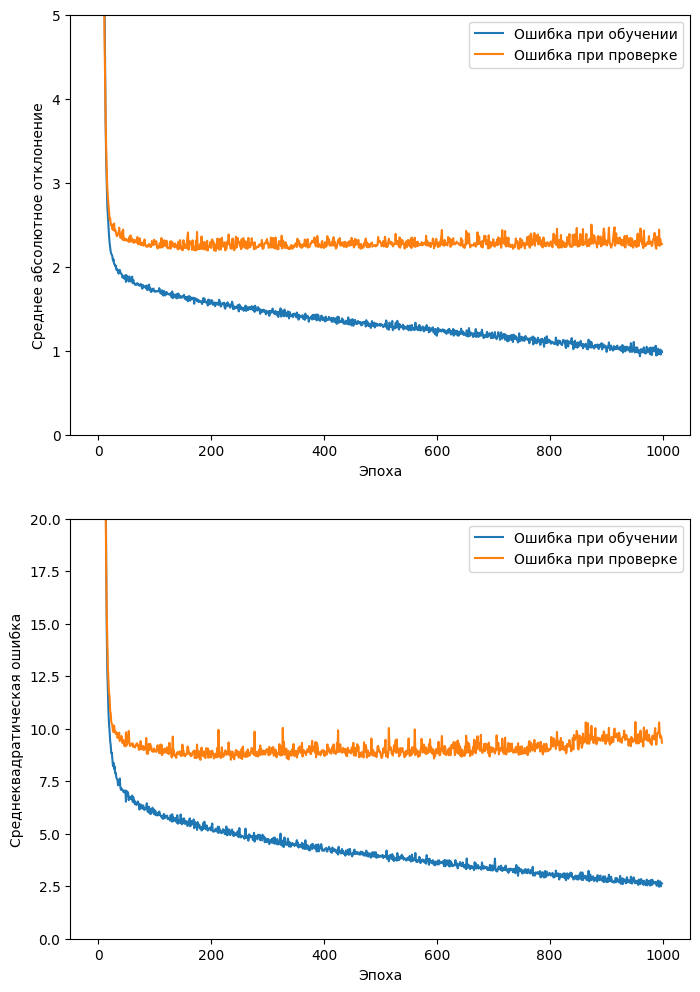

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Эпоха')
  plt.ylabel('Среднее абсолютное отклонение')
  plt.plot(hist['epoch'], hist['mae'],
           label='Ошибка при обучении')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Ошибка при проверке')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Эпоха')
  plt.ylabel('Среднеквадратическая ошибка')
  plt.plot(hist['epoch'], hist['mse'],
           label='Ошибка при обучении')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Ошибка при проверке')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



............................................................................................

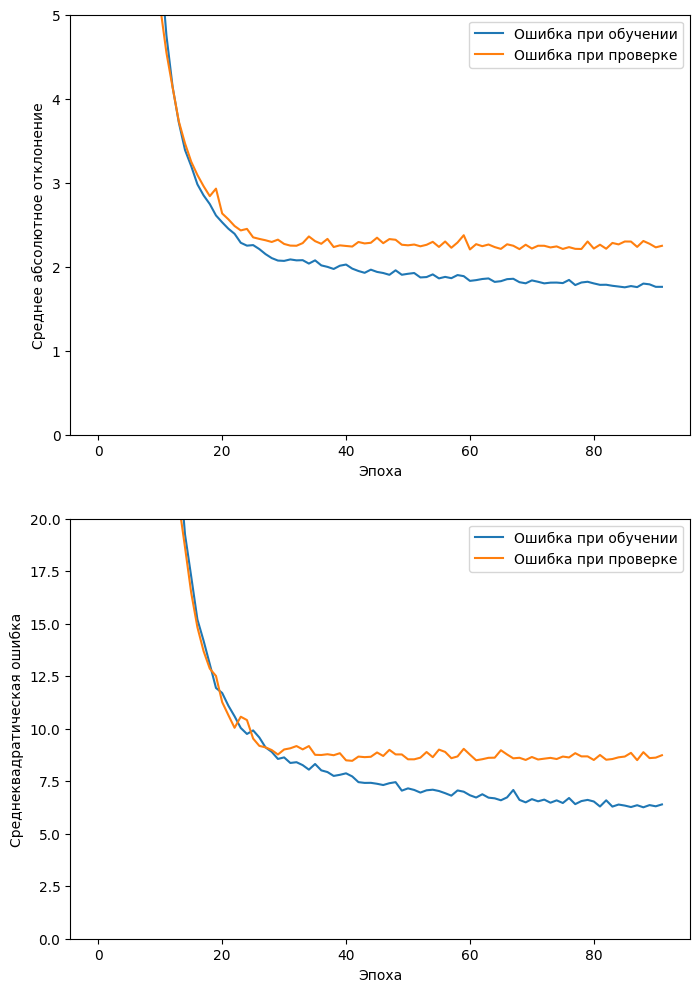

In [ ]:
model = build_model()

# Параметр patience определяет количество эпох, которые можно пропустить без улучшений
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Среднее абсолютное отклонение на проверочных данных: {:5.2f} галлон на милю".format(mae))

Среднее абсолютное отклонение на проверочных данных:  1.93 галлон на милю


Делаем предсказания

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


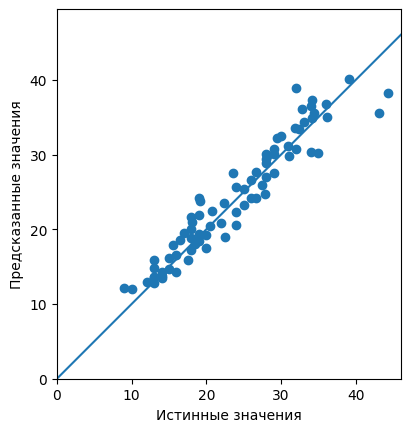

In [ ]:
#сравнение линии регрессии с реальными данными
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

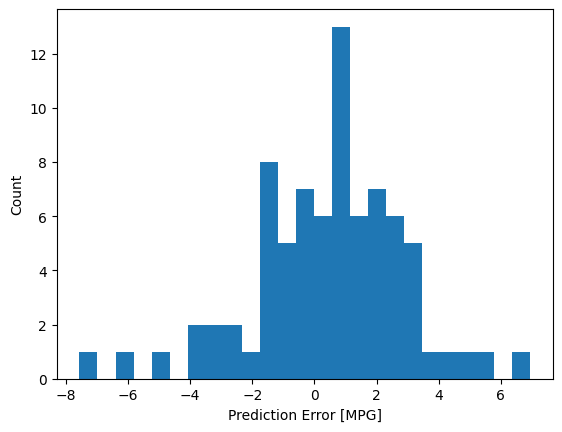

In [ ]:
#количество ошибок предсказания
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

План выполненной работы:
1. были загружены данные, проведена проверка пропуски, удалены ряды с пропусками, закодированы категориальные данные
2. была проведена проверка значений и разбиение на обучающую и тестовую категорию, данные были нормализованы
3. модель была построена, проверена и обучена (1000 эпох)
4. количество эпох было сокращено до +-90, поскольку после улучшений ошибки нет
5. были сделаны предсказания, поскроен график линейной регрессии (значения совпали), а также график количества ошибок

Выводы:
1. После 90 эпохи ошибка не уменьшалась
2. Отклонение в 1.90 галлон на миль = +- 447 литров на 100 км, что крайне много, ошибка значительная